# Aplicación de la segmentación


## ¿Qué es la segmentación?


En los cuadernos anteriores, solo hemos abordado problemas de clasificación, es decir, predecir una clase a partir de una imagen (por ejemplo, "esta es una imagen del número 5" o "esta es una imagen de un gato").
Sin embargo, existen otras dos categorías de análisis de imágenes: la **detección** y la **segmentación**.


### Detección de objetos en una imagen


La detección de objetos en una imagen consiste en dibujar un recuadro alrededor del objeto de interés. Por ejemplo, si queremos detectar gatos y la imagen contiene un perro y un gato, entrenamos un modelo para dibujar un cuadro alrededor del gato.

A continuación, se muestra una imagen para visualizar la idea de la detección de objetos:

![Detección](./images/detection.png)

Imagen extraída del [artículo](https://machinethink.net/blog/object-detection-with-yolo/).


Como pueden imaginar, esta es una tarea muy interesante en el campo del procesamiento de imágenes, pero no es lo que abordaremos en este cuaderno.


### Segmentación de objetos en una imagen


La segmentación tiene como objetivo determinar la clase a la que pertenece cada píxel de la imagen (por ejemplo, el píxel en la posición $(120, 300)$ pertenece a un perro). El objetivo es obtener información muy precisa sobre el contenido de la imagen a nivel de píxel.

![Segmentación](./images/Segmentation.png)

Imagen extraída del [artículo](https://towardsai.net/p/l/machine-learning-7).


Existen varios tipos de segmentación:

- **Segmentación semántica**: Consiste en clasificar cada píxel de la imagen independientemente de la instancia (por ejemplo, todos los coches se colorearán de rojo). Este es el tipo de segmentación que se muestra en la imagen anterior.
- **Segmentación de instancias**: Aquí, cada instancia de una misma clase se segmenta con un color diferente (por ejemplo, el primer coche en rojo, el segundo en naranja, etc.).
- También existen otros tipos de segmentación. Para más información, pueden consultar este [artículo](https://medium.com/@arulkumarark1924/image-segmentation-techniques-for-computer-vision-bc5a68a4aa10).


En este cuaderno, realizaremos un ejemplo de **segmentación semántica**.


## Conjunto de datos utilizado


Utilizamos el conjunto de datos [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), que contiene un total de $7349$ imágenes, de las cuales $4978$ son de perros y $2371$ de gatos. Para cada imagen, se incluyen anotaciones de segmentación, así como un recuadro alrededor de la cabeza del animal.

![Oxford Pet](./images/oxford_pet.jpg)


Solo utilizaremos la anotación correspondiente a la segmentación del animal.


Para obtener y utilizar este conjunto de datos, es necesario descargarlo directamente desde el sitio web, ya que la versión proporcionada por `torchvision` no incluye las máscaras de segmentación.


Cuando el conjunto de datos que deseas utilizar no está disponible directamente en `torchvision`, es necesario crear una clase que herede de la clase `Dataset` para especificar cómo gestionar los datos de dicho conjunto.


In [7]:
# Import nécessaire pour le projet
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import numpy as np

In [ ]:
class datasetSeg(Dataset):
  def __init__(self, path):
    self.path = path
    self.imagesPath,self.masksPath=self.loadDataset()
    
    self.resize=T.Resize((100, 100)) # Valeur de resize pour les images
    self.toTensor=T.ToTensor()
  
  def __len__(self):
    return len(self.imagesPath)
  
  def loadDataset(self): # Récuperation des liens vers les images et les annotations
    images=os.listdir(self.path+"images/")
    images=sorted(images)
    masks=os.listdir(self.path+"annotations/trimaps/")
    masks=sorted(masks)
    masks=[ mask for mask in masks if "._" not in mask ]
    images=[image for image in images if ".mat" not in image]
    return images, masks
  
  def __getitem__(self, index):
    image=Image.open(self.path+"images/"+self.imagesPath[index]).convert('RGB')
    # Resize des images et récuperation du masque de segmentation
    trimap=self.resize(Image.open(self.path+"annotations/trimaps/"+self.masksPath[index]).convert('L'))
    trimap=np.array(trimap)
    # Création des masques pour les classes
    class1 = (trimap == 1).astype(np.uint8)  
    class2 = (trimap == 2).astype(np.uint8)  
    class3 = (trimap == 3).astype(np.uint8)
    mask = np.stack([class1, class2, class3], axis=0)
    return self.toTensor(self.resize(image)), torch.tensor(mask)
        

Ahora que hemos creado nuestra clase de conjunto de datos, podemos cargar el conjunto y examinar su contenido.


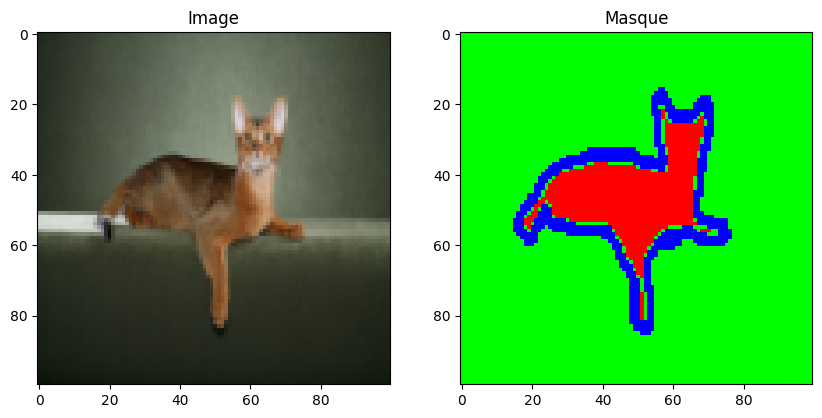

In [9]:
dataset=datasetSeg(path="./../data/OxfordPets/")
img=dataset[0][0].permute(1,2,0).numpy()
msk = dataset[0][1].permute(1, 2, 0).numpy() * 1.0

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img)
axs[0].set_title('Image')
axs[1].imshow(msk)
axs[1].set_title('Masque')
plt.show()

Tenemos la imagen y su segmentación. Ahora es el momento de dividir nuestro conjunto de datos y definir nuestros *dataloaders*:


In [10]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset,[0.7, 0.2, 0.1])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=True)

## Arquitectura del modelo: U-Net


A diferencia de un problema de clasificación de imágenes, la salida de nuestra red neuronal debe tener la misma dimensión que la entrada en términos de resolución y un canal por cada clase que deseamos segmentar (por ejemplo, si queremos segmentar diez clases en imágenes de entrada de tamaño $224 \times 224 \times 3$, la salida será de tamaño $224 \times 224 \times 10$).
Una arquitectura clásica de red convolucional, donde la resolución disminuye progresivamente hasta llegar a una capa totalmente conectada de clasificación, no es adecuada para este caso.
En su lugar, podemos utilizar la arquitectura **U-Net**.


A continuación, se muestra cómo es la arquitectura U-Net:

![U-Net](./images/unet.png)

Figura extraída de este [artículo](https://datasciencetoday.net/index.php/en-us/deep-learning/228-unet).


Como pueden observar, la arquitectura es bastante atípica. Consiste en una **ruta de contracción** (llamada *codificador*), que reduce el tamaño de la imagen como en una CNN clásica, y una **ruta de expansión** (llamada *decodificador*), que aumenta el tamaño de la imagen hasta alcanzar una resolución idéntica a la entrada. Las conexiones indicadas por las flechas negras permiten conservar información local precisa, mientras que la parte codificador/decodificador permite detectar relaciones más abstractas entre diferentes píxeles.

Esta arquitectura fue introducida por primera vez para la segmentación de imágenes médicas en este [artículo](https://arxiv.org/abs/1505.04597). Actualmente, se utiliza en numerosos campos (segmentación, reducción de ruido, difusión, etc.).


### Acerca de la convolución transpuesta


Hemos visto en detalle las capas de convolución, que permiten realizar operaciones en imágenes con parámetros entrenables. Sabemos que, gracias al parámetro *stride*, las capas de convolución permiten conservar la resolución inicial o reducirla.
Sin embargo, a veces es necesario **aumentar la resolución de la imagen** (por ejemplo, para la parte del decodificador de la U-Net descrita anteriormente).


Para ello, podemos considerar varias opciones:

- **Interpolación seguida de una convolución**: Similar al *pooling*, pero en sentido inverso, esta idea consiste en utilizar una función de interpolación no entrenable para ampliar artificialmente la imagen.
- **Convolución transpuesta**: Esta operación actúa como la inversa de una convolución y permite aumentar el tamaño de la imagen. A continuación, se muestra un ejemplo de convolución transpuesta con un *kernel* de tamaño $2 \times 2$. Es una operación que contiene parámetros entrenables.

![Convolución Transpuesta](./images/convT.png)

Figura extraída de este [artículo](https://d2l.ai/chapter_computer-vision/transposed-conv.html).


Para quienes deseen profundizar y conocer las diferencias principales entre ambas técnicas, recomiendo leer este [artículo](https://distill.pub/2016/deconv-checkerboard/).

En nuestra implementación, utilizaremos la **convolución transpuesta**.


### Implementación en PyTorch


Es hora de implementar la arquitectura U-Net en PyTorch:


In [11]:
# Fonction pour combiner couche de convolution, activation ReLU et BatchNorm pour éviter les copier coller 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
# Idem mais avec la convolution transposée
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )

class UNet(nn.Module):
  def __init__(self, num_classes=3):
    super().__init__()
    # encoder
    self.conv1=conv_relu_bn(3, 64, 3, 1, 1)
    self.conv2=conv_relu_bn(64, 64, 3, 1, 1)
    self.maxPool1=nn.MaxPool2d(2, 2)
    
    self.conv3=conv_relu_bn(64, 128, 3, 1, 1)
    self.conv4=conv_relu_bn(128, 128, 3, 1, 1)
    self.maxPool2=nn.MaxPool2d(2, 2)
    
    #Module central
    self.conv5=conv_relu_bn(128, 256, 3, 1, 1)
    self.conv6=conv_relu_bn(256, 256, 3, 1, 1)
    
    # Décodeur
    self.convT1=convT_relu_bn(256, 128, 4, 2, 1)
    self.conv7=conv_relu_bn(256, 128, 3, 1, 1)
    
    self.convT2=convT_relu_bn(128, 64, 4, 2, 1)
    self.conv8=conv_relu_bn(128, 64, 3, 1, 1)
    
    # On va prédire un channel par classe
    self.conv9=conv_relu_bn(64, num_classes, 3, 1, 1)     
    self.sigmoid=nn.Sigmoid()
  
  def forward(self,x):
    # Encodeur
    x=self.conv1(x)
    x1=self.conv2(x)
    
    x=self.maxPool1(x1)
    
    x=self.conv3(x)
    x2=self.conv4(x)
    x=self.maxPool2(x2)
    
    # Module central
    x=self.conv5(x)
    x=self.conv6(x)

    #Décodeur
    x=self.convT1(x)
    x=torch.cat((x,x2),dim=1)
    x=self.conv7(x)
    
    x=self.convT2(x)
    x=torch.cat((x,x1),dim=1)
    x=self.conv8(x)
    
    x=self.conv9(x)
    x=self.sigmoid(x)
    return x

## Entrenamiento del modelo


Para entrenar el modelo, no distinguiremos entre perros y gatos, sino que buscaremos simplemente identificar los píxeles que pertenecen al animal, los píxeles del borde y los píxeles del fondo.


In [12]:
# Nous défissons
model=UNet(num_classes=3).to('cuda')
criterion=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
epochs=5

La base de datos es bastante extensa y el modelo es bastante profundo. Es posible que el entrenamiento dure varias decenas de minutos si su GPU no es muy potente. *(Si no tiene GPU, no recomiendo intentar entrenar el modelo).*


In [13]:
for epoch in range(epochs):
  train_loss=0
  for images,masks in train_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    optimizer.zero_grad()
    seg=model(images)
    loss=criterion(seg,masks)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(f"step {epoch} train loss {train_loss/len(train_dataloader)}")  
  val_loss=0
  for images,masks in val_dataloader:
    images=images.to('cuda')
    masks=masks.to('cuda').float()
    with torch.no_grad():
      seg=model(images)
      loss=criterion(seg,masks)
    val_loss += loss.item() 
  print(f"step {epoch} train loss {val_loss/len(val_dataloader)}")  

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


step 0 train loss 0.9442852522120063
step 0 train loss 0.9016501573806114
step 1 train loss 0.8738441905121744
step 1 train loss 0.8578698165873264
step 2 train loss 0.8354099944785789
step 2 train loss 0.8258832287281117
step 3 train loss 0.8052123431806211
step 3 train loss 0.7977393028583932
step 4 train loss 0.7819347337440208
step 4 train loss 0.7781971261856404


Ahora podemos calcular la precisión en nuestros datos de prueba.


In [14]:
def calculate_class_accuracy(preds, masks, class_idx):
  #On convertit les prédictions en valeur entre 0 et 1 pour chaque classe
  preds = torch.argmax(preds, dim=1)
  
  # On ne récupère que les pixels de la classe d'intêret
  preds_class = (preds == class_idx).float()
  masks_class = (masks == class_idx).float()
  
  # Calculer la précision pour la classe choisie
  correct = (preds_class == masks_class).float()
  accuracy = correct.sum() / correct.numel()
  return accuracy

model.eval()
test_accuracy = 0.0
num_batches = 0


with torch.no_grad(): # Désactivation du calcul du gradient
  for images, masks in test_dataloader:
    images = images.to('cuda')
    masks = masks.to('cuda').long()
    
    seg = model(images)
    
    # On calcule la précision pour la classe d'intêret (0 correspond à la segmentation de l'animal)
    class_idx = 0
    batch_accuracy = calculate_class_accuracy(seg, masks, class_idx)
    
    test_accuracy += batch_accuracy.item()
    num_batches += 1

# On calcule la précision moyenne sur l'ensemble du dataset de test
test_accuracy /= num_batches
print(f'Précision pour la segmentation de l animal : {test_accuracy*100:.1f}%')

Précision pour la segmentation de l animal : 43.4%


### Visualización


Podemos visualizar los resultados de nuestro entrenamiento en una imagen tomada del conjunto de datos de prueba. Para una tarea de segmentación, es interesante observar qué resultado se obtiene en uno o varios ejemplos. Si ejecuta varias veces el siguiente bloque de código, podrá ver la generación en diferentes imágenes.


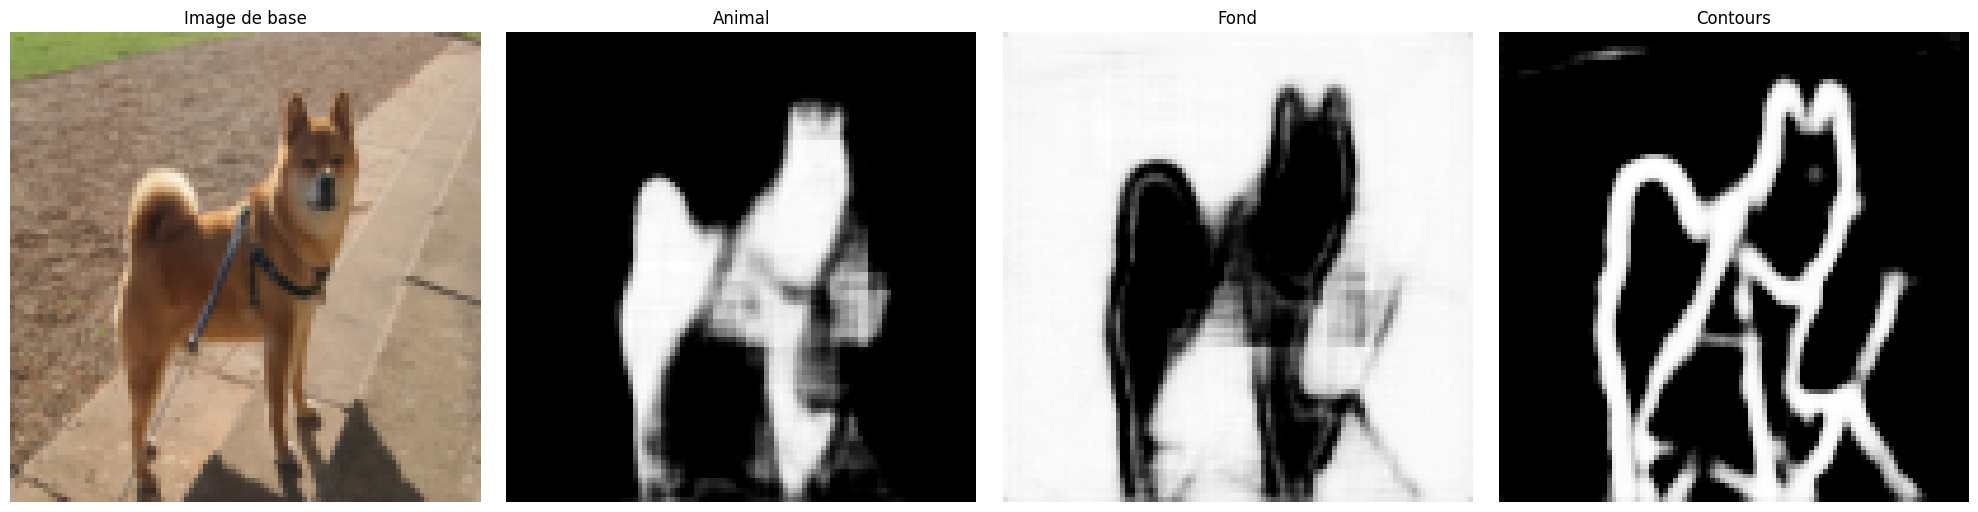

In [32]:
images,labels=next(iter(test_dataloader))

#Isolons un élément 
image=images[0].unsqueeze(0).to('cuda') # Le unsqueeze permet de garder la dimension batch
with torch.no_grad():
  seg=model(image)
    
# Affichons la segmentation prédite par le modèle pour cet élément
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Image de base')
axs[0].axis('off')

axs[1].imshow(seg[0][0].cpu().numpy(), cmap='gray')
axs[1].set_title('Animal')
axs[1].axis('off')

axs[2].imshow(seg[0][1].cpu().numpy(), cmap='gray')
axs[2].set_title('Fond')
axs[2].axis('off')

axs[3].imshow(seg[0][2].cpu().numpy(), cmap='gray')
axs[3].set_title('Contours')
axs[3].axis('off')

plt.tight_layout()
plt.show()

A pesar de la puntuación relativamente baja de $43\%$ de precisión, observamos que la segmentación es correcta en la mayoría de las imágenes.


### Ejercicio propuesto


Para practicar, pueden intentar mejorar el rendimiento del modelo. Algunas opciones incluyen:
- Aumentar el número de capas.
- Cambiar el número de filtros en las capas.
- Agregar *dropout*.
- Utilizar *batch normalization*.
- Incrementar el número de *epochs* de entrenamiento.
- Modificar la *tasa de aprendizaje (learning rate)*.

¡Intenten maximizar el rendimiento de su modelo de segmentación!
